### Baseline Climate Conditions
#### This notebook implements Water Stress data from CEPALGEO from 2000-2020 in 5 year increments to develop an understanding of the resilience to climate pressures in Latin America going forward.

MAP 1: Water Stress Change Analysis (2000-2020)
Workspace set to: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\ClimateVulnerability.gdb

STEP 1: Discovering Water Stress Layers (2000-2020)
✓ Found 2000: Map 1: Water Stress Change 2000-2020
✓ Found 2020: Water_2020_Corrected
✓ Found 2015: Water_2015_Corrected
✓ Found 2010: Water_2010_Corrected
✓ Found 2005: Water_2005_Corrected
✓ Found 2000: Water_2000_Corrected
✓ Found 2020: water_2020_JSONToFeatures
✓ Found 2015: water_2015_JSONToFeatures
✓ Found 2010: water_2010_JSONToFeatures
✓ Found 2005: water_2005_JSONToFeatures
✓ Found 2000: water_2000_JSONToFeatures

✓ Found all 5 water stress layers!

STEP 2: Extracting Data from 'value' Field

Processing 2000...
  2000: Using fields - Admin: 'ADMIN', Value: 'value'
    Valid samples: [('Antigua and Barbuda', 7.63), ('Barbados', 101.25), ('Belize', 1.26)]
    ⚠ Found 22/47 placeholder values (-88888888)

Processing 2005...
  2005: Using fields - Admin: 'ADMIN', Value: 'value'
    Va

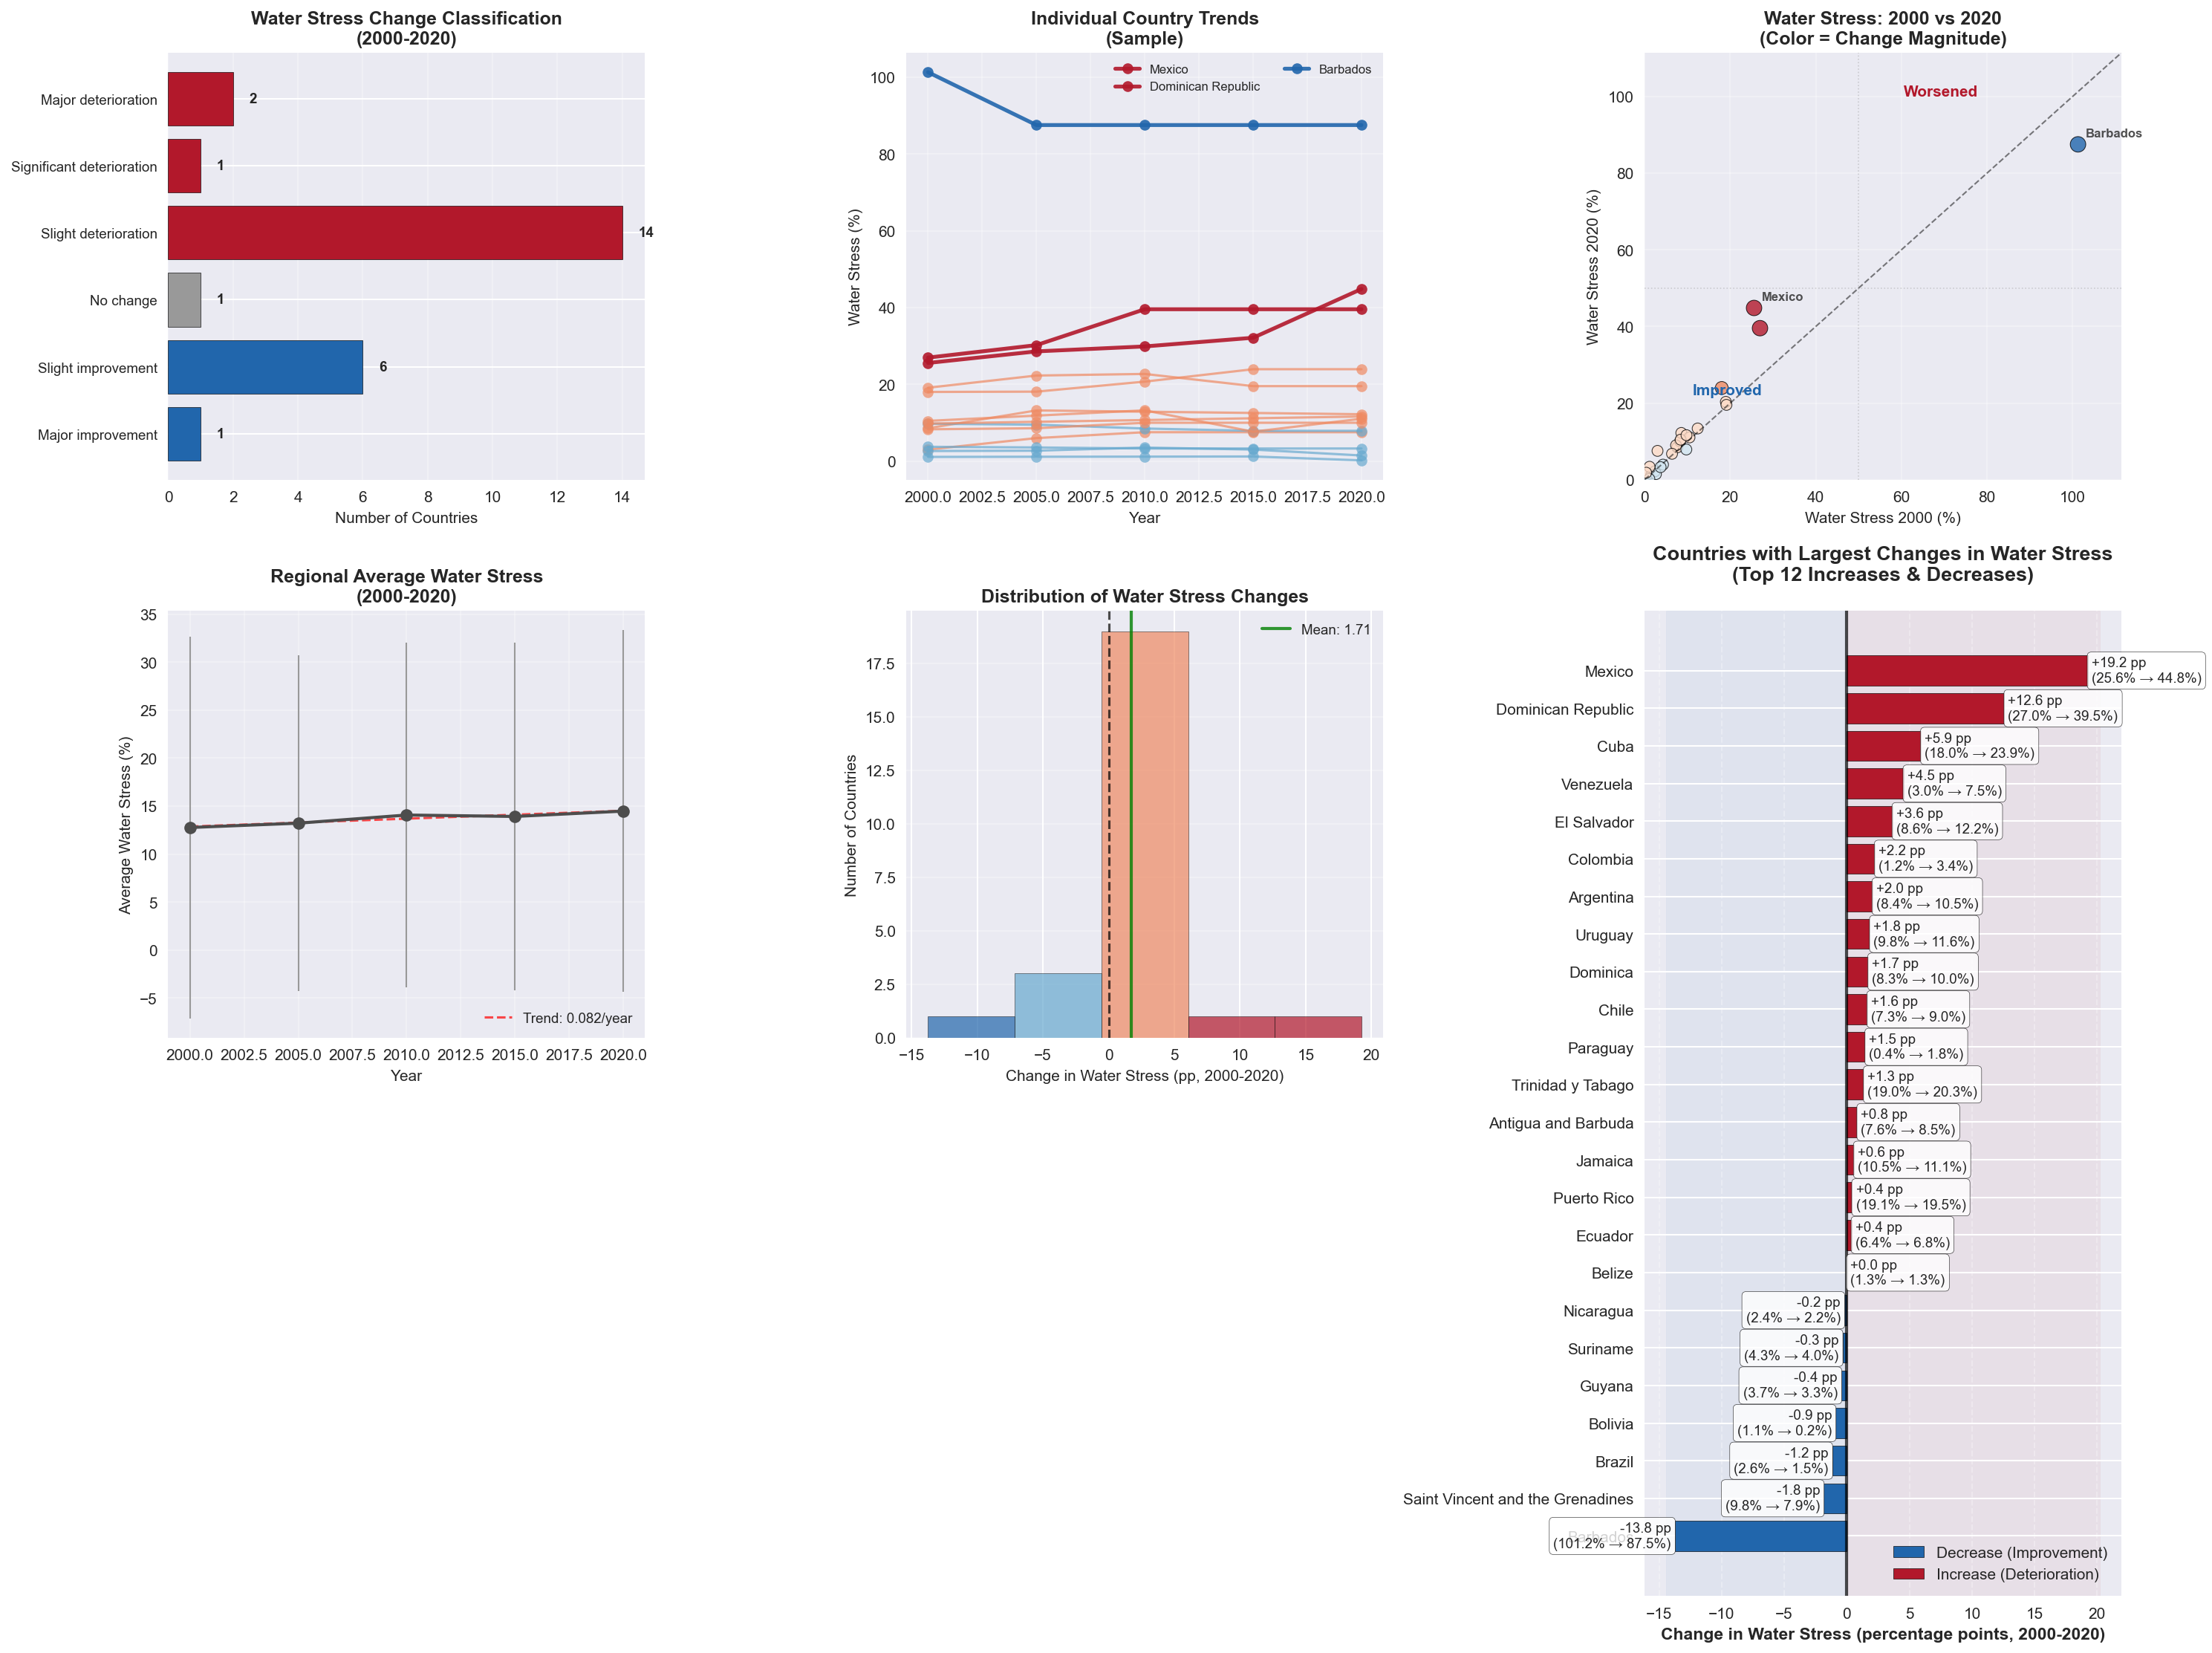

✓ Saved comprehensive analysis figure to: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\water_stress_analysis_corrected.png


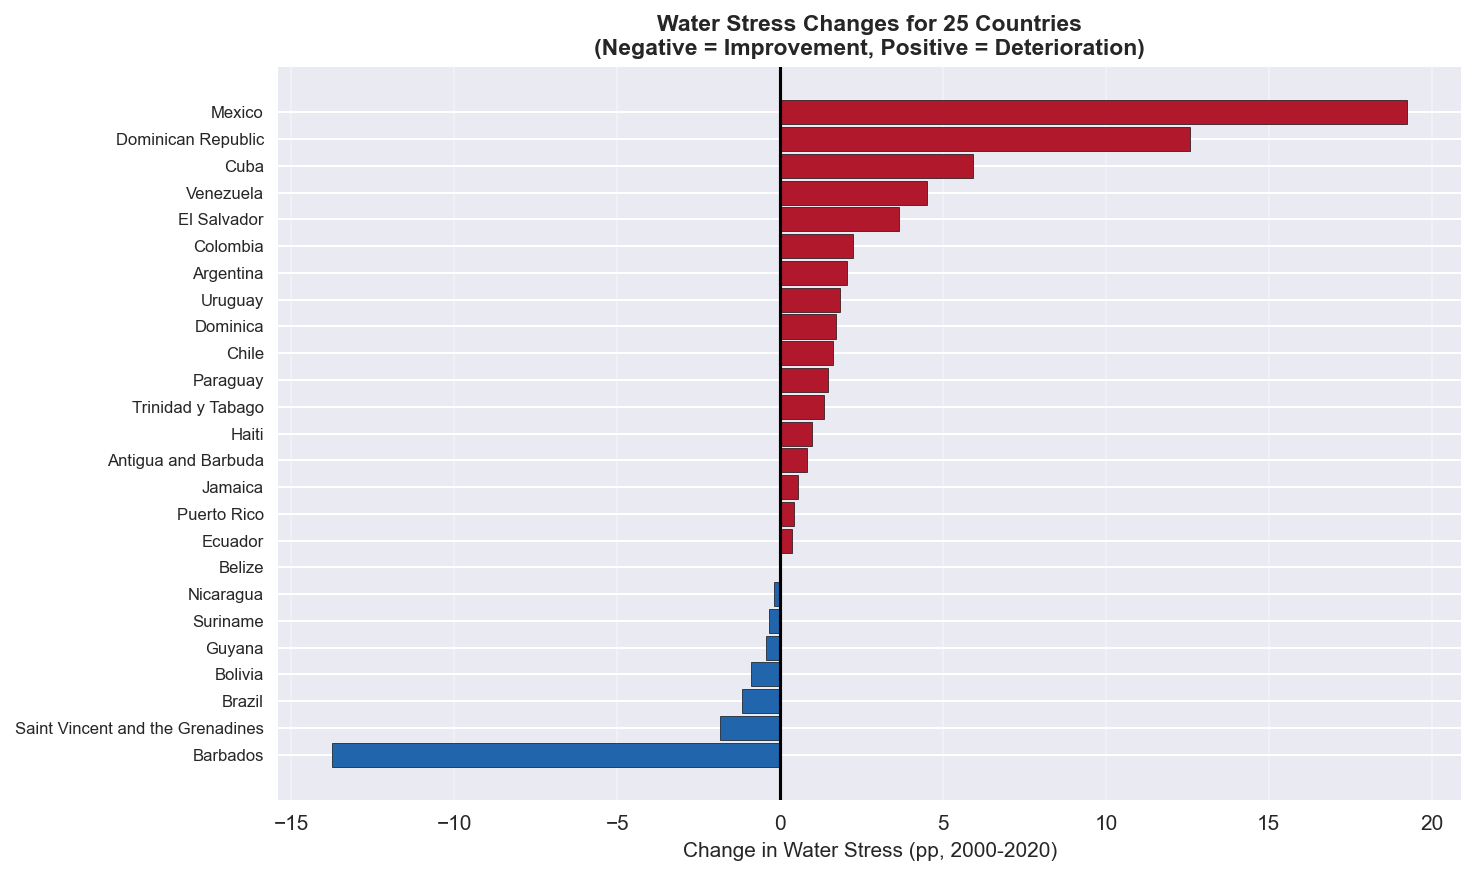

✓ Saved simple changes chart to: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\water_stress_changes_simple.png

✓ Exported cleaned analysis data to: C:\Users\Liliana\Documents\ArcGIS\Projects\658_Lab4_LWV\water_stress_analysis_cleaned.csv


In [19]:
# MAP 1: WATER STRESS CHANGE CHOROPLETH (2000-2020)
# Import necessary libraries
import arcpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# Set up visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
%matplotlib inline

# Set up workspace
print("="*70)
print("MAP 1: Water Stress Change Analysis (2000-2020)")
print("="*70)

arcpy.env.overwriteOutput = True
project = arcpy.mp.ArcGISProject("CURRENT")
project_path = project.filePath
project_folder = os.path.dirname(project_path)
gdb_path = os.path.join(project_folder, "ClimateVulnerability.gdb")

# Create a geodatabase
if not arcpy.Exists(gdb_path):
    arcpy.CreateFileGDB_management(os.path.dirname(gdb_path), "ClimateVulnerability.gdb")
    print(f"Created geodatabase: {gdb_path}")

arcpy.env.workspace = gdb_path
print(f"Workspace set to: {gdb_path}")

# STEP 1: DISCOVER AND VERIFY ALL WATER STRESS LAYERS


print("\n" + "="*60)
print("STEP 1: Discovering Water Stress Layers (2000-2020)")
print("="*60)

active_map = project.listMaps()[0]
years = [2000, 2005, 2010, 2015, 2020]

# Find all water layers
water_layers = {}
for layer in active_map.listLayers():
    layer_name = layer.name
    if "water" in layer_name.lower():
        # Extract year from layer name
        for year in years:
            if str(year) in layer_name:
                water_layers[year] = (layer_name, layer)
                print(f"✓ Found {year}: {layer_name}")
                break

# Check if found all years
missing_years = [year for year in years if year not in water_layers]
if missing_years:
    print(f"\n⚠ Missing years: {missing_years}")
    print("Available layers:")
    for layer in active_map.listLayers():
        if "water" in layer.name.lower():
            print(f"  - {layer.name}")
    raise Exception(f"Missing water layers for: {missing_years}")
else:
    print(f"\n✓ Found all {len(years)} water stress layers!")

# ============================================================================
# STEP 2: EXTRACT DATA FROM ALL YEARS - USING "value" FIELD
# ============================================================================

print("\n" + "="*60)
print("STEP 2: Extracting Data from 'value' Field")
print("="*60)

def extract_water_data_corrected(layer_name, layer_obj, year):
    """Extract water stress data using CORRECT 'value' field"""
    try:
        # Get data source
        if hasattr(layer_obj, 'dataSource') and layer_obj.dataSource:
            data_source = layer_obj.dataSource
        else:
            data_source = layer_name
        
        # Create feature class
        fc_name = f"Water_{year}_Corrected"
        fc_path = os.path.join(gdb_path, fc_name)
        
        if arcpy.Exists(fc_path):
            arcpy.Delete_management(fc_path)
        
        # Copy features
        arcpy.CopyFeatures_management(data_source, fc_path)
        
        # Verify "value" field exists
        fields = [f.name for f in arcpy.ListFields(fc_path)]
        if "value" not in fields:
            print(f"❌ ERROR: 'value' field not found in {year} data!")
            print(f"  Available fields: {fields}")
            
            # Look for alternative
            alt_fields = [f for f in fields if 'value' in f.lower() and f != 'values_']
            if alt_fields:
                print(f"  Possible alternatives: {alt_fields}")
                return fc_path, "ADMIN", alt_fields[0]
            else:
                return None, None, None
        
        # Get ADMIN field
        admin_field = "ADMIN" if "ADMIN" in fields else "NAME" if "NAME" in fields else None
        if not admin_field and fields:
            # Find first text field that's not geometry
            for field in fields:
                field_obj = [f for f in arcpy.ListFields(fc_path) if f.name == field][0]
                if field_obj.type == 'String' and field not in ['Shape']:
                    admin_field = field
                    break
        
        print(f"  {year}: Using fields - Admin: '{admin_field}', Value: 'value'")
        
        # Check sample data and filter out -88888888 values
        valid_samples = []
        placeholder_count = 0
        total_count = 0
        
        with arcpy.da.SearchCursor(fc_path, [admin_field, "value"]) as cursor:
            for admin, value in cursor:
                total_count += 1
                if value is not None:
                    # Check for placeholder value (-88888888 or similar)
                    if value <= -88800000:  # Extreme negative placeholder
                        placeholder_count += 1
                    elif len(valid_samples) < 3:  # Keep first 3 valid samples
                        valid_samples.append((admin, value))
        
        if valid_samples:
            print(f"    Valid samples: {valid_samples}")
        if placeholder_count > 0:
            print(f"    ⚠ Found {placeholder_count}/{total_count} placeholder values (-88888888)")
        
        return fc_path, admin_field, "value"
        
    except Exception as e:
        print(f"  Error extracting {year}: {e}")
        return None, None, None

# Extract data for all years
year_data = {}
for year in years:
    layer_name, layer_obj = water_layers[year]
    print(f"\nProcessing {year}...")
    fc_path, admin_field, value_field = extract_water_data_corrected(layer_name, layer_obj, year)
    
    if fc_path and value_field:
        year_data[year] = {
            'fc_path': fc_path,
            'admin_field': admin_field,
            'value_field': value_field
        }
    else:
        print(f"❌ Failed to extract {year} data")

# ============================================================================
# STEP 3: CREATE MASTER DATASET WITH DATA CLEANING
# ============================================================================

print("\n" + "="*60)
print("STEP 3: Creating Master Dataset with Data Cleaning")
print("="*60)

# Start with 2000 data as base
base_year = 2000
base_fc = year_data[base_year]['fc_path']
base_admin_field = year_data[base_year]['admin_field']

# Create master feature class
master_fc = os.path.join(gdb_path, "WaterStress_Master_Corrected")
if arcpy.Exists(master_fc):
    arcpy.Delete_management(master_fc)

arcpy.CopyFeatures_management(base_fc, master_fc)
print(f"✓ Created master feature class: {master_fc}")

# Add fields for all years
for year in years:
    if year in year_data:
        field_name = f"WS_{year}"
        if not arcpy.ListFields(master_fc, field_name):
            arcpy.AddField_management(master_fc, field_name, "DOUBLE")
        print(f"  Added field: {field_name}")

# Add change calculation fields
change_fields = ['WS_Change_Total', 'WS_Change_Pct', 'WS_Trend', 'WS_Avg', 'WS_Slope']
for field in change_fields:
    if not arcpy.ListFields(master_fc, field):
        arcpy.AddField_management(master_fc, field, "DOUBLE")

# Add classification field
if not arcpy.ListFields(master_fc, "Change_Class"):
    arcpy.AddField_management(master_fc, "Change_Class", "SHORT")

print("✓ Added all analysis fields")

# ============================================================================
# STEP 4: POPULATE MASTER DATASET WITH CLEANED DATA
# ============================================================================

print("\n" + "="*60)
print("STEP 4: Populating with Cleaned Data (Filtering -88888888 values)")
print("="*60)

# First, create a lookup dictionary for each year's CLEANED data
year_values = {}
placeholder_counts = {}

for year in years:
    if year in year_data:
        fc_path = year_data[year]['fc_path']
        admin_field = year_data[year]['admin_field']
        value_field = year_data[year]['value_field']
        
        values_dict = {}
        placeholder_count = 0
        total_count = 0
        
        with arcpy.da.SearchCursor(fc_path, [admin_field, value_field]) as cursor:
            for admin, value in cursor:
                total_count += 1
                if admin and value is not None:
                    # FILTER OUT PLACEHOLDER VALUES (-88888888)
                    if value <= -88800000:  # Extreme negative placeholder
                        placeholder_count += 1
                        values_dict[admin] = None  # Mark as missing
                    else:
                        # Handle any other data issues
                        if isinstance(value, (int, float)):
                            values_dict[admin] = float(value)
                        else:
                            try:
                                values_dict[admin] = float(value)
                            except:
                                values_dict[admin] = None
        
        year_values[year] = values_dict
        placeholder_counts[year] = placeholder_count
        
        valid_count = sum(1 for v in values_dict.values() if v is not None)
        print(f"  {year}: {valid_count} valid values, {placeholder_count} placeholders filtered out")

# Now update master feature class with CLEANED data
print("\nUpdating master feature class with cleaned data...")

# Get all update fields
year_field_names = [f"WS_{year}" for year in years]
update_fields = [base_admin_field] + year_field_names + ['WS_Change_Total', 'WS_Change_Pct', 'WS_Trend', 'Change_Class']

records_updated = 0
records_with_change = 0

with arcpy.da.UpdateCursor(master_fc, update_fields) as cursor:
    for row in cursor:
        admin = str(row[0]).strip() if row[0] else None
        
        if admin:
            # Populate year values (using cleaned data)
            year_vals = []
            for i, year in enumerate(years, 1):  # Start at 1 because row[0] is admin
                if year in year_values and admin in year_values[year]:
                    value = year_values[year][admin]
                    row[i] = value
                    year_vals.append(value)
                else:
                    row[i] = None
                    year_vals.append(None)
            
            # Calculate changes if BOTH 2000 and 2020 CLEAN data
            ws_2000 = row[1]  # WS_2000 is at index 1
            ws_2020 = row[5]  # WS_2020 is at index 5
            
            if (ws_2000 is not None and ws_2020 is not None and 
                not np.isnan(ws_2000) and not np.isnan(ws_2020)):
                
                # Total change (2020 - 2000)
                change_total = ws_2020 - ws_2000
                row[len(year_field_names) + 1] = change_total  # WS_Change_Total
                
                # Percentage change (handle zero 2000 values carefully)
                if abs(ws_2000) > 0.0001:  # Not essentially zero
                    change_pct = (change_total / abs(ws_2000)) * 100
                else:
                    # If 2000 is zero or near-zero, percentage change is undefined
                    # Use absolute change as fallback
                    change_pct = change_total * 100  # Scale for consistency
                row[len(year_field_names) + 2] = change_pct  # WS_Change_Pct
                
                # Simple trend classification
                if change_total > 10:
                    trend = 1.0  # Major deterioration
                    change_class = 7
                elif change_total > 5:
                    trend = 0.75  # Significant deterioration
                    change_class = 6
                elif change_total > 0:
                    trend = 0.5  # Slight deterioration
                    change_class = 5
                elif abs(change_total) < 0.001:  # Essentially zero
                    trend = 0.0  # No change
                    change_class = 4
                elif change_total > -5:
                    trend = -0.5  # Slight improvement
                    change_class = 3
                elif change_total > -10:
                    trend = -0.75  # Significant improvement
                    change_class = 2
                else:
                    trend = -1.0  # Major improvement
                    change_class = 1
                
                row[len(year_field_names) + 3] = trend  # WS_Trend
                row[len(update_fields) - 1] = change_class  # Change_Class
                
                records_updated += 1
                if abs(change_total) > 0.001:  # Non-zero change
                    records_with_change += 1
            else:
                # Missing data for 2000 or 2020
                row[len(year_field_names) + 1] = None  # WS_Change_Total
                row[len(year_field_names) + 2] = None  # WS_Change_Pct
                row[len(year_field_names) + 3] = None  # WS_Trend
                row[len(update_fields) - 1] = 0  # Change_Class = No data
        
        cursor.updateRow(row)

print(f"✓ Updated {records_updated} records with complete 2000-2020 data")
print(f"  {records_with_change} records have non-zero changes")
print(f"  Placeholder values filtered: {sum(placeholder_counts.values())} total")

# ============================================================================
# STEP 5: CALCULATE AVERAGE AND TREND METRICS
# ============================================================================

print("\n" + "="*60)
print("STEP 5: Calculating Average and Linear Trend")
print("="*60)

# Calculate average water stress across all years (excluding nulls)
calc_avg_code = """
def calculate_avg(ws2000, ws2005, ws2010, ws2015, ws2020):
    years = [ws2000, ws2005, ws2010, ws2015, ws2020]
    valid_vals = [v for v in years if v is not None and v > -88800000]
    if valid_vals:
        return sum(valid_vals) / len(valid_vals)
    else:
        return None
"""

arcpy.CalculateField_management(
    master_fc,
    "WS_Avg",
    "calculate_avg(!WS_2000!, !WS_2005!, !WS_2010!, !WS_2015!, !WS_2020!)",
    "PYTHON3",
    calc_avg_code
)
print("✓ Calculated average water stress")

# ============================================================================
# STEP 6: GENERATE COMPREHENSIVE STATISTICS
# ============================================================================

print("\n" + "="*60)
print("STEP 6: Generating Statistics from CLEANED Data")
print("="*60)

# Extract cleaned data for analysis
data_records = []
with arcpy.da.SearchCursor(master_fc, [base_admin_field, "WS_2000", "WS_2005", "WS_2010", 
                                       "WS_2015", "WS_2020", "WS_Change_Total", "Change_Class"]) as cursor:
    for row in cursor:
        # Only include records with valid 2000 and 2020 data
        if row[1] is not None and row[5] is not None:  # WS_2000 and WS_2020
            data_records.append({
                'Country': row[0],
                'WS_2000': row[1],
                'WS_2005': row[2],
                'WS_2010': row[3],
                'WS_2015': row[4],
                'WS_2020': row[5],
                'Change_Total': row[6] if row[6] is not None else 0,
                'Change_Class': row[7] if row[7] is not None else 0
            })

df = pd.DataFrame(data_records)

if len(df) > 0:
    print(f"\n✅ ANALYSIS SUCCESSFUL!")
    print(f"Countries with complete cleaned data: {len(df)}")
    
    # Calculate statistics
    print("\n" + "-"*50)
    print("WATER STRESS STATISTICS (Cleaned Data)")
    print("-"*50)
    
    print(f"Average 2000 water stress: {df['WS_2000'].mean():.1f}%")
    print(f"Average 2020 water stress: {df['WS_2020'].mean():.1f}%")
    print(f"Average change (2000-2020): {df['Change_Total'].mean():.2f} percentage points")
    print(f"Median change: {df['Change_Total'].median():.2f} pp")
    print(f"Std deviation of change: {df['Change_Total'].std():.2f} pp")
    
    # Classify changes
    class_names = {
        1: "Major improvement (< -10 pp)",
        2: "Significant improvement (-10 to -5 pp)",
        3: "Slight improvement (-5 to 0 pp)",
        4: "No change (0 pp)",
        5: "Slight deterioration (0 to 5 pp)",
        6: "Significant deterioration (5 to 10 pp)",
        7: "Major deterioration (> 10 pp)",
        0: "Insufficient data"
    }
    
    # Count changes by class
    print("\n" + "-"*50)
    print("CHANGE DISTRIBUTION")
    print("-"*50)
    
    change_counts = df['Change_Class'].value_counts().sort_index()
    total_with_data = len(df)
    
    for class_code in sorted(change_counts.keys()):
        count = change_counts[class_code]
        percentage = (count / total_with_data) * 100
        print(f"  {class_names.get(class_code, f'Class {class_code}')}:")
        print(f"    {count} countries ({percentage:.1f}%)")
        
        # Show sample countries for each class
        if count > 0:
            samples = df[df['Change_Class'] == class_code].head(3)
            for _, row in samples.iterrows():
                print(f"      - {row['Country']}: {row['WS_2000']:.1f}% → {row['WS_2020']:.1f}% ({row['Change_Total']:+.1f} pp)")
    
    # Top increases and decreases
    print("\n" + "-"*50)
    print("TOP 5 LARGEST INCREASES (Deterioration)")
    print("-"*50)
    top_increases = df.nlargest(5, 'Change_Total')
    for i, (_, row) in enumerate(top_increases.iterrows(), 1):
        print(f"  {i}. {row['Country']}: {row['WS_2000']:.1f}% → {row['WS_2020']:.1f}% (+{row['Change_Total']:.1f} pp)")
    
    print("\n" + "-"*50)
    print("TOP 5 LARGEST DECREASES (Improvement)")
    print("-"*50)
    top_decreases = df.nsmallest(5, 'Change_Total')
    for i, (_, row) in enumerate(top_decreases.iterrows(), 1):
        print(f"  {i}. {row['Country']}: {row['WS_2000']:.1f}% → {row['WS_2020']:.1f}% ({row['Change_Total']:+.1f} pp)")
    
    # Time series analysis
    print("\n" + "-"*50)
    print("TIME SERIES ANALYSIS")
    print("-"*50)
    
    # Calculate regional averages for each year
    yearly_avgs = {}
    for year in years:
        col_name = f'WS_{year}'
        yearly_avgs[year] = df[col_name].mean()
        print(f"  {year} regional average: {yearly_avgs[year]:.1f}%")
    
    # Overall trend
    if len(yearly_avgs) >= 2:
        first_year = min(yearly_avgs.keys())
        last_year = max(yearly_avgs.keys())
        overall_trend = yearly_avgs[last_year] - yearly_avgs[first_year]
        print(f"  Overall regional trend ({first_year}-{last_year}): {overall_trend:+.1f} pp")
    
else:
    print("❌ No complete data records found after cleaning!")
    print("Check if placeholder filtering is too aggressive.")

# ============================================================================
# STEP 7: ADD MASTER LAYER TO MAP
# ============================================================================

print("\n" + "="*60)
print("STEP 7: Adding Corrected Layer to Map")
print("="*60)

# Add to map
try:
    active_map.addDataFromPath(master_fc)
    
    # Rename for clarity
    for layer in active_map.listLayers():
        if master_fc in layer.dataSource:
            layer.name = "Map 1: Water Stress Change 2000-2020 (Corrected)"
            print(f"✓ Added and renamed layer: '{layer.name}'")
            break
            
except Exception as e:
    print(f"⚠ Could not add layer: {e}")
    print(f"Manual: Add {master_fc} from Catalog pane")

# ============================================================================
# STEP 8: CREATE COMPREHENSIVE VISUALIZATIONS (CLEANED DATA)
# ============================================================================

print("\n" + "="*60)
print("STEP 8: Creating Visualizations from Cleaned Data")
print("="*60)

if len(df) > 0:
    # Create a multi-panel figure
    fig = plt.figure(figsize=(20, 15))
    
    # ========== SUBPLOT 1: Change Classification ==========
    ax1 = plt.subplot(3, 3, 1)
    
    # Prepare classification data
    class_counts = df['Change_Class'].value_counts().sort_index()
    class_labels = [class_names.get(c, f'Class {c}') for c in class_counts.index]
    
    # Colors: Blue for improvement, Gray for neutral, Red for deterioration
    colors = []
    for class_code in class_counts.index:
        if class_code <= 3:
            colors.append('#2166AC')  # Blue - improvement
        elif class_code == 4:
            colors.append('#999999')  # Gray - no change
        else:
            colors.append('#B2182B')  # Red - deterioration
    
    # Create horizontal bar chart
    bars = ax1.barh(range(len(class_counts)), class_counts.values, color=colors, edgecolor='black')
    ax1.set_yticks(range(len(class_counts)))
    ax1.set_yticklabels([l.split(' (')[0] for l in class_labels], fontsize=9)
    ax1.set_xlabel('Number of Countries', fontsize=10)
    ax1.set_title('Water Stress Change Classification\n(2000-2020)', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add count labels
    for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
        ax1.text(count + 0.5, i, str(count), va='center', fontweight='bold', fontsize=9)
    
    # ========== SUBPLOT 2: Time Series Trends ==========
    ax2 = plt.subplot(3, 3, 2)
    
    # Plot individual country trends (sample)
    years_num = years
    sample_size = min(15, len(df))
    
    # Get diverse sample: top increases, decreases, and random
    sample_df = pd.concat([
        df.nlargest(5, 'Change_Total'),
        df.nsmallest(5, 'Change_Total'),
        df.sample(min(5, len(df) - 10)) if len(df) > 10 else df
    ]).drop_duplicates()
    
    for _, country_data in sample_df.iterrows():
        trend_vals = [country_data[f'WS_{year}'] for year in years_num]
        
        # Color by overall trend
        if country_data['Change_Total'] > 10:
            color = '#B2182B'  # Dark red - major deterioration
            linewidth = 2.5
            alpha = 0.9
        elif country_data['Change_Total'] > 0:
            color = '#EF8A62'  # Light red - deterioration
            linewidth = 1.5
            alpha = 0.7
        elif country_data['Change_Total'] < -10:
            color = '#2166AC'  # Dark blue - major improvement
            linewidth = 2.5
            alpha = 0.9
        elif country_data['Change_Total'] < 0:
            color = '#67A9CF'  # Light blue - improvement
            linewidth = 1.5
            alpha = 0.7
        else:
            color = '#999999'  # Gray - no change
            linewidth = 1
            alpha = 0.5
        
        ax2.plot(years_num, trend_vals, marker='o', linewidth=linewidth, 
                color=color, alpha=alpha, 
                label=country_data['Country'] if abs(country_data['Change_Total']) > 10 else "")
    
    ax2.set_xlabel('Year', fontsize=10)
    ax2.set_ylabel('Water Stress (%)', fontsize=10)
    ax2.set_title('Individual Country Trends\n(Sample)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best', fontsize=8, ncol=2)
    
    # ========== SUBPLOT 3: Scatter Plot (2000 vs 2020) ==========
    ax3 = plt.subplot(3, 3, 3)
    
    # Color points by change magnitude
    scatter_colors = []
    scatter_sizes = []
    for _, row in df.iterrows():
        if row['Change_Total'] > 10:
            scatter_colors.append('#B2182B')  # Dark red
            scatter_sizes.append(100)
        elif row['Change_Total'] > 5:
            scatter_colors.append('#EF8A62')  # Light red
            scatter_sizes.append(70)
        elif row['Change_Total'] > 0:
            scatter_colors.append('#FDDBC7')  # Very light red
            scatter_sizes.append(50)
        elif abs(row['Change_Total']) < 0.1:
            scatter_colors.append('#999999')  # Gray
            scatter_sizes.append(30)
        elif row['Change_Total'] > -5:
            scatter_colors.append('#D1E5F0')  # Very light blue
            scatter_sizes.append(50)
        elif row['Change_Total'] > -10:
            scatter_colors.append('#67A9CF')  # Light blue
            scatter_sizes.append(70)
        else:
            scatter_colors.append('#2166AC')  # Dark blue
            scatter_sizes.append(100)
    
    scatter = ax3.scatter(df['WS_2000'], df['WS_2020'], 
                         c=scatter_colors, s=scatter_sizes, alpha=0.8, 
                         edgecolor='black', linewidth=0.5)
    
    # Add diagonal line (no change)
    max_val = max(df[['WS_2000', 'WS_2020']].max().max(), 100) * 1.1
    ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1, label='No Change')
    
    # Add quadrant lines at 50% (high stress threshold)
    ax3.axhline(y=50, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)
    ax3.axvline(x=50, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)
    
    # Label quadrants
    ax3.text(max_val*0.7, max_val*0.9, 'Worsened', fontsize=10, 
             fontweight='bold', color='#B2182B', ha='right')
    ax3.text(max_val*0.1, max_val*0.2, 'Improved', fontsize=10, 
             fontweight='bold', color='#2166AC', ha='left')
    
    ax3.set_xlabel('Water Stress 2000 (%)', fontsize=10)
    ax3.set_ylabel('Water Stress 2020 (%)', fontsize=10)
    ax3.set_title('Water Stress: 2000 vs 2020\n(Color = Change Magnitude)', 
                  fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, max_val)
    ax3.set_ylim(0, max_val)
    
    # Label extreme cases
    extreme_cases = df[(abs(df['Change_Total']) > 15) | (df['WS_2020'] > 80)].head(10)
    for _, row in extreme_cases.iterrows():
        ax3.annotate(row['Country'], (row['WS_2000'], row['WS_2020']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8, fontweight='bold')
    
    # ========== SUBPLOT 4: Regional Time Series Average ==========
    ax4 = plt.subplot(3, 3, 4)
    
    # Calculate regional averages for each year
    regional_avgs = []
    regional_stds = []
    for year in years:
        regional_avgs.append(df[f'WS_{year}'].mean())
        regional_stds.append(df[f'WS_{year}'].std())
    
    # Plot with error bars
    ax4.errorbar(years, regional_avgs, yerr=regional_stds, 
                 fmt='o-', linewidth=2, markersize=8, capsize=5,
                 color='#4D4D4D', ecolor='#999999', elinewidth=1)
    
    ax4.set_xlabel('Year', fontsize=10)
    ax4.set_ylabel('Average Water Stress (%)', fontsize=10)
    ax4.set_title('Regional Average Water Stress\n(2000-2020)', 
                  fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(years, regional_avgs, 1)
    p = np.poly1d(z)
    ax4.plot(years, p(years), 'r--', alpha=0.7, linewidth=1.5, 
             label=f'Trend: {z[0]:.3f}/year')
    ax4.legend(loc='best', fontsize=9)
    
    # ========== SUBPLOT 5: Histogram of Changes ==========
    ax5 = plt.subplot(3, 3, 5)
    
    # Create histogram of changes
    n_bins = min(20, len(df) // 5)
    if n_bins > 0:
        hist_data = df['Change_Total']
        
        # Color bins by direction
        n, bins, patches = ax5.hist(hist_data, bins=n_bins, edgecolor='black', alpha=0.7)
        
        # Color each bin
        for i in range(len(patches)):
            bin_center = (bins[i] + bins[i+1]) / 2
            if bin_center < -5:
                patches[i].set_facecolor('#2166AC')  # Blue - improvement
            elif bin_center < 0:
                patches[i].set_facecolor('#67A9CF')  # Light blue
            elif bin_center == 0:
                patches[i].set_facecolor('#999999')  # Gray
            elif bin_center < 5:
                patches[i].set_facecolor('#EF8A62')  # Light red
            else:
                patches[i].set_facecolor('#B2182B')  # Red - deterioration
        
        ax5.axvline(x=0, color='black', linewidth=1.5, linestyle='--', alpha=0.7)
        ax5.axvline(x=hist_data.mean(), color='green', linewidth=2, 
                   linestyle='-', alpha=0.8, label=f'Mean: {hist_data.mean():.2f}')
        
        ax5.set_xlabel('Change in Water Stress (pp, 2000-2020)', fontsize=10)
        ax5.set_ylabel('Number of Countries', fontsize=10)
        ax5.set_title('Distribution of Water Stress Changes', 
                      fontsize=12, fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
        ax5.legend(loc='best', fontsize=9)
    
    # ========== SUBPLOT 6: Top Changes Bar Chart ==========
    ax6 = plt.subplot(3, 3, (6, 9))  # Span three columns
    
    # Combine top increases and decreases
    top_n = 12
    top_changes = pd.concat([
        df.nlargest(top_n, 'Change_Total'),
        df.nsmallest(top_n, 'Change_Total')
    ]).drop_duplicates().sort_values('Change_Total')
    
    # Create horizontal bars
    bar_colors = ['#2166AC' if x < 0 else '#B2182B' for x in top_changes['Change_Total']]
    bars = ax6.barh(range(len(top_changes)), top_changes['Change_Total'], 
                    color=bar_colors, edgecolor='black', height=0.8)
    
    # Add value labels with 2000→2020 values
    for i, (bar, row) in enumerate(zip(bars, top_changes.itertuples())):
        change_text = f'{row.Change_Total:+.1f} pp'
        value_text = f'({row.WS_2000:.1f}% → {row.WS_2020:.1f}%)'
        ax6.text(row.Change_Total + (0.3 if row.Change_Total >= 0 else -0.3), i, 
                f'{change_text}\n{value_text}', va='center', fontsize=9,
                ha='left' if row.Change_Total >= 0 else 'right',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax6.set_yticks(range(len(top_changes)))
    ax6.set_yticklabels(top_changes['Country'], fontsize=10)
    ax6.set_xlabel('Change in Water Stress (percentage points, 2000-2020)', 
                   fontsize=11, fontweight='bold')
    ax6.set_title(f'Countries with Largest Changes in Water Stress\n(Top {top_n} Increases & Decreases)', 
                  fontsize=13, fontweight='bold', pad=20)
    ax6.axvline(x=0, color='black', linewidth=2, alpha=0.7)
    ax6.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add a subtle background for positive/negative regions
    ax6.axvspan(0.01, top_changes['Change_Total'].max() * 1.05, 
                alpha=0.05, color='#B2182B', zorder=0)
    ax6.axvspan(top_changes['Change_Total'].min() * 1.05, -0.01, 
                alpha=0.05, color='#2166AC', zorder=0)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2166AC', label='Decrease (Improvement)', edgecolor='black'),
        Patch(facecolor='#B2182B', label='Increase (Deterioration)', edgecolor='black')
    ]
    ax6.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    
    # Save the comprehensive figure
    fig_path = os.path.join(project_folder, "water_stress_analysis_corrected.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✓ Saved comprehensive analysis figure to: {fig_path}")
    
    # ========== CREATE ADDITIONAL SIMPLE CHANGE MAP PREVIEW ==========
    fig2, ax = plt.subplots(figsize=(10, 6))
    
    # Simple bar chart of changes for quick reference
    changes_sorted = df.sort_values('Change_Total')
    colors_simple = ['#2166AC' if x < 0 else '#B2182B' for x in changes_sorted['Change_Total']]
    
    bars = ax.barh(range(len(changes_sorted)), changes_sorted['Change_Total'], 
                   color=colors_simple, edgecolor='black', height=0.9)
    
    ax.set_yticks(range(len(changes_sorted)))
    ax.set_yticklabels(changes_sorted['Country'], fontsize=8)
    ax.set_xlabel('Change in Water Stress (pp, 2000-2020)', fontsize=10)
    ax.set_title(f'Water Stress Changes for {len(changes_sorted)} Countries\n(Negative = Improvement, Positive = Deterioration)', 
                 fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linewidth=1.5)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    simple_chart_path = os.path.join(project_folder, "water_stress_changes_simple.png")
    plt.savefig(simple_chart_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved simple changes chart to: {simple_chart_path}")
    
else:
    print("⚠ No data for visualization creation")

# Export final cleaned data
csv_path = os.path.join(project_folder, "water_stress_analysis_cleaned.csv")
df.to_csv(csv_path, index=False, encoding='utf-8')
print(f"\n✓ Exported cleaned analysis data to: {csv_path}")



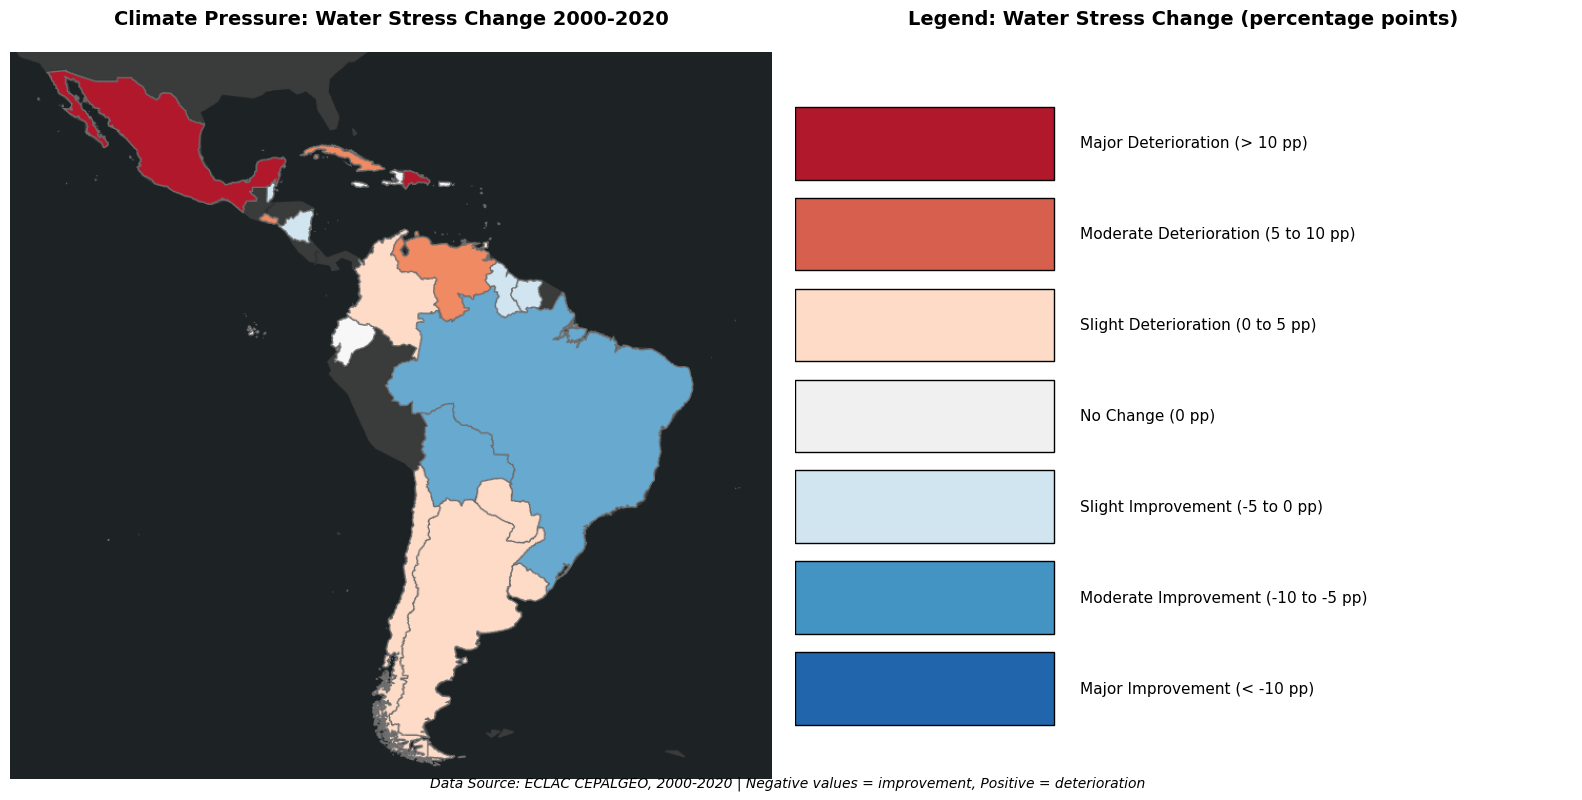

MAP 1 INTERPRETATION GUIDE

BLUE COLORS: Water stress IMPROVED (climate pressure decreased)
- Dark Blue: Major improvement (>10 pp decrease in water stress)
- Medium Blue: Moderate improvement (5-10 pp decrease)
- Light Blue: Slight improvement (0-5 pp decrease)

GRAY: No significant change

RED COLORS: Water stress WORSENED (climate pressure increased)
- Light Red: Slight deterioration (0-5 pp increase)
- Medium Red: Moderate deterioration (5-10 pp increase)
- Dark Red: Major deterioration (>10 pp increase)

KEY INSIGHT: Shows which countries are facing increasing/decreasing
water scarcity pressures - a core climate change impact in the region.



In [4]:
# Map 1: Climate - Water Stress Change Notebook
# ==============================================

import matplotlib.pyplot as plt
from PIL import Image
import os

# Set up the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Load map screenshot from Desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
map1_path = os.path.join(desktop_path, "Map1_Climate.png")  

if os.path.exists(map1_path):
    # Display the map
    img = Image.open(map1_path)
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Climate Pressure: Water Stress Change 2000-2020', 
                  fontsize=14, fontweight='bold', pad=20)
else:
    ax1.text(0.5, 0.5, f"File not found:\n{map1_path}", 
             ha='center', va='center', fontsize=12)
    ax1.axis('off')

# Create the legend
legend_colors = ['#2166AC', '#4393C3', '#D1E5F0', '#F0F0F0', '#FDDBC7', '#D6604D', '#B2182B']
legend_labels = [
    'Major Improvement (< -10 pp)',
    'Moderate Improvement (-10 to -5 pp)',
    'Slight Improvement (-5 to 0 pp)',
    'No Change (0 pp)',
    'Slight Deterioration (0 to 5 pp)',
    'Moderate Deterioration (5 to 10 pp)',
    'Major Deterioration (> 10 pp)'
]

# Create legend patches
for i, (color, label) in enumerate(zip(legend_colors, legend_labels)):
    ax2.barh(i, 1, color=color, edgecolor='black', height=0.8)
    ax2.text(1.1, i, label, va='center', fontsize=11)

ax2.set_xlim(0, 3)
ax2.set_ylim(-1, len(legend_labels))
ax2.axis('off')
ax2.set_title('Legend: Water Stress Change (percentage points)', 
              fontsize=14, fontweight='bold', pad=20)

# Add data source
plt.figtext(0.5, 0.01, 'Data Source: ECLAC CEPALGEO, 2000-2020 | Negative values = improvement, Positive = deterioration', 
            ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

# Print map interpretation
print("="*70)
print("MAP 1 INTERPRETATION GUIDE")
print("="*70)
print("""
BLUE COLORS: Water stress IMPROVED (climate pressure decreased)
- Dark Blue: Major improvement (>10 pp decrease in water stress)
- Medium Blue: Moderate improvement (5-10 pp decrease)
- Light Blue: Slight improvement (0-5 pp decrease)

GRAY: No significant change

RED COLORS: Water stress WORSENED (climate pressure increased)
- Light Red: Slight deterioration (0-5 pp increase)
- Medium Red: Moderate deterioration (5-10 pp increase)
- Dark Red: Major deterioration (>10 pp increase)

KEY INSIGHT: Shows which countries are facing increasing/decreasing
water scarcity pressures - a core climate change impact in the region.
""")